# Cross-Validation and the Test Set

In the last lecture, we saw how keeping some data hidden from our model could help us to get a clearer understanding of whether or not the model was overfitting. This time, we'll introduce a common automated framework for handling this task, called **cross-validation**. We'll also incorporate a designated **test set**, which we won't touch until the very end of our analysis to get an overall view of the performance of our model. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# assumes that you have run the function retrieve_data() 
# from "Introduction to ML in Practice" in ML_3.ipynb
titanic = pd.read_csv("data.csv")
titanic

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


We are again going to use the `train_test_split` function to divide our data in two. This time, however, we are not going to be using the holdout data to determine the model complexity. Instead, we are going to hide the holdout data until the very end of our analysis. We'll use a different technique for handling the model complexity. 

In [3]:
from sklearn.model_selection import train_test_split

np.random.seed(1234) # for reproducibility
train, test = train_test_split(titanic, test_size = 0.2) # hold out 20% of data

We again need to clean our data: 

In [4]:
from sklearn import preprocessing
def prep_titanic_data(data_df):
    df = data_df.copy()
    le = preprocessing.LabelEncoder()
    df['Sex'] = le.fit_transform(df['Sex'])
    df = df.drop(['Name'], axis = 1)
    
    X = df.drop(['Survived'], axis = 1).values
    y = df['Survived'].values
    
    return(X, y)

In [5]:
X_train, y_train = prep_titanic_data(train)
X_test,  y_test  = prep_titanic_data(test)

## K-fold Cross-Validation

The idea of k-fold cross validation is to take a small piece of our training data, say 10%, and use that as a mini test set. We train the model on the remaining 90%, and then evaluate on the 10%. We then take a *different* 10%, train on the remaining 90%, and so on. We do this many times, and finally average the results to get an overall average picture of how the model might be expected to perform on the real test set. Cross-validation is a highly efficient tool for estimating the optimal complexity of a model. 

<figure class="image" style="width:100%">
  <img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="Illustration of k-fold cross validation. The training data is sequentially partitioned into 'folds', each of which is used as mini-testing data exactly once. The image shows five-fold validation, with four boxes of training data and one box of testing data. The diagram then indicates a final evaluation against additional testing data not used in cross-validation." width="600px">
    <br>
    <caption><i>K-fold cross-validation. Source: scikit-learn docs.</i></caption>
</figure>

The good folks at `scikit-learn` have implemented a function called `cross_val_score` which automates this entire process. It repeatedly selects holdout data; trains the model; and scores the model against the holdout data. While exceptions apply, you can often use `cross_val_score` as a plug-and-play replacement for `model.fit()` and `model.score()` during your model selection phase. 

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn import tree

# make a model
T = tree.DecisionTreeClassifier(max_depth = 3)

# 10-fold cross validation: hold out 10%, train on the 90%, repeat 10 times. 
cv_scores = cross_val_score(T, X_train, y_train, cv=10)
cv_scores

array([0.8028169 , 0.73239437, 0.76056338, 0.81690141, 0.83098592,
       0.8028169 , 0.81690141, 0.78873239, 0.85915493, 0.84285714])

In [7]:
cv_scores.mean()

0.8054124748490945

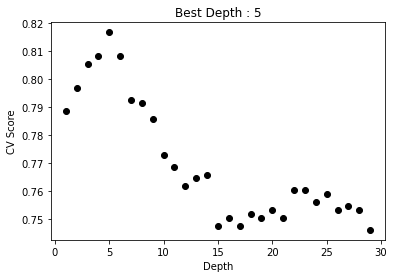

In [8]:
fig, ax = plt.subplots(1)

best_score = 0

for d in range(1,30):
    T = tree.DecisionTreeClassifier(max_depth = d)
    cv_score = cross_val_score(T, X_train, y_train, cv=10).mean()
    ax.scatter(d, cv_score, color = "black")
    if cv_score > best_score:
        best_depth = d
        best_score = cv_score

l = ax.set(title = "Best Depth : " + str(best_depth),
       xlabel = "Depth", 
       ylabel = "CV Score")

Now that we have a reasonable estimate of the optimal depth, we can try evaluating against the unseen testing data. 

In [9]:
T = tree.DecisionTreeClassifier(max_depth = best_depth)
T.fit(X_train, y_train)
T.score(X_test, y_test)

0.8426966292134831

Great! We even got slightly higher accuracy on the test set than we did in validation, although this is rare. ?

# Machine Learning Workflow: The Big Picture

We now have all of the elements that we need to execute the core machine learning workflow. At a high-level, here's what should go into a machine task:

1. Separate out the test set from your data. 
2. Clean and prepare your data if needed. It is best practice to clean your training and test data separately. It's convenient to write a function for this. 
3. Identify a set of candidate models (e.g. decision trees with depth up to 30, logistic models with between 1 and 3 variables, etc). 
4. Use a validation technique (k-fold cross-validation is usually sufficient) to estimate how your models will perform on the unseen test data. Select the best model as measured by validation. 
5. Finally, score the best model against the test set and report the result. 

Of course, this isn't all there is to data science -- you still need to do exploratory analysis; interpret your model; etc. etc. 

We'll discuss model interpretation further in a coming lecture. 